## Answering Business Questions using SQL Project

In this project SQL will be used to answer several questions about the chinook database

## General Setup

In [25]:
#imports
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
db = 'chinook.db'

## Function for Running Queries

In [26]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql_query(q, conn)

## Function for Running Commands

In [27]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        return conn.execute(c)

## Function for Showing all Tables

In [28]:
def show_tables():
    q1 = '''SELECT
            name,
            type
    FROM sqlite_master
    WHERE type IN ("table", "view")'''
    return run_query(q1)

In [29]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Finding Most Profitable Genres in USA

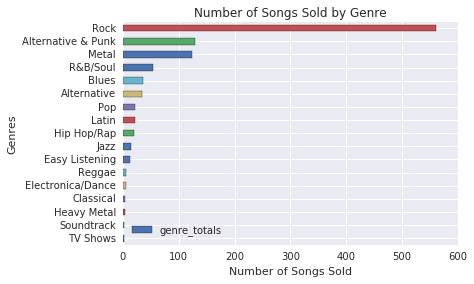

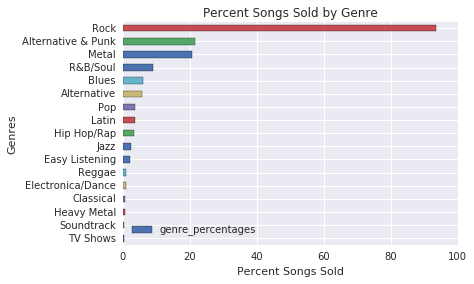

In [30]:
q2 = """
WITH usa_totals AS
    (SELECT
    i.invoice_id,
    i.billing_country country,
    i.total
    FROM invoice i 
    WHERE i.billing_country == "USA")
    


SELECT
g.name genre_name,
COUNT(ut.invoice_id) genre_totals,
CAST(COUNT(ut.invoice_id) AS float) / (SELECT COUNT(invoice_id) / 100 FROM invoice) genre_percentages
FROM track t
INNER JOIN genre g ON g.genre_id = t.genre_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN usa_totals ut ON ut.invoice_id = il.invoice_id
GROUP BY genre_name
ORDER BY 2
"""
results = run_query(q2)
# In numbers
fig1 = results.set_index(keys = results['genre_name']).plot.barh(y = 'genre_totals')
fig1.set_title('Number of Songs Sold by Genre')
fig1.set_ylabel('Genres')
fig1.set_xlabel('Number of Songs Sold')

plt.show()

# In percentages

fig2 = results.set_index(keys = results['genre_name']).plot.barh(y = 'genre_percentages')
fig2.set_title('Percent Songs Sold by Genre')
fig2.set_ylabel('Genres')
fig2.set_xlabel('Percent Songs Sold')

plt.show()


By looking at the sales numbers, the recommendation would be to use
"Red Tone"
"Meteor and the Girls"
and "Slim Jim Bites"

as the three new artists

In [31]:
q3 = '''
SELECT
e.first_name || ' ' || e.last_name employee_name,
SUM(i.total) total_sales,
COUNT(i.customer_id) no_customers,
SUM(i.total)/COUNT(i.customer_id) average_sale_per_customer
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
'''

run_query(q3)

,employee_name,total_sales,no_customers,average_sale_per_customer
0,Jane Peacock,1731.51,212,8.167500
1,Margaret Park,1584.00,214,7.401869
2,Steve Johnson,1393.92,188,7.414468


The table above shows, that Jane Peacock has the highest amount of revenue. She also has the highest revenue per customer on average, as even though she has 2 customers less than Margaret park, she has about $150 more in sales revenue

## Analyzing Sales Data by Country

Now the database will be analyzed relative to country regarding:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value.

Countries with only one Customer will be secluded in a 'Other category'

In [32]:
q4 = '''
WITH single_countries AS
    (SELECT c.country, 
    count(c.customer_id) no_customers
    from customer c
    GROUP BY 1
    HAVING count(c.customer_id) = 1),
    
    multi_countries AS
    (SELECT
    c.country,
    COUNT(c.customer_id) no_customers
    FROM customer c
    GROUP BY 1
    HAVING count(c.customer_id) != 1),
    
    invoice_customers AS
    (SELECT
    customer_id,
    COUNT(invoice_id) no_invoices,
    SUM(total) sum_total
    FROM invoice
    GROUP BY customer_id),
    
    first_query as
    (SELECT
    c.country,
    COUNT(c.customer_id) total_no_customers,
    SUM(ic.sum_total) tot_val_sales,
    SUM(ic.sum_total) / COUNT(c.customer_id) avg_spent_cust,
    SUM(ic.no_invoices) no_invoices
    FROM customer c
    INNER JOIN invoice_customers ic ON ic.customer_id = c.customer_id
    GROUP BY c.country),
    
    second_query as
    (SELECT * FROM first_query
    WHERE total_no_customers != 1
    
    UNION
    
    SELECT
    'OTHER' country,
    SUM(total_no_customers) total_no_customers,
    SUM(tot_val_sales) tot_val_sales,
    AVG(avg_spent_cust) avg_spent_cust,
    SUM(no_invoices) no_invoices
    FROM first_query
    WHERE total_no_customers = 1)

SELECT
country,
total_no_customers customers,
tot_val_sales total_sales,
tot_val_sales / no_invoices average_order,
avg_spent_cust customer_total_spent
FROM
    (SELECT * ,
    CASE
        WHEN country = 'OTHER' THEN 1
        ELSE 0
    END
    AS omgwhydidthistakesolong
    FROM second_query
    ORDER BY omgwhydidthistakesolong, 3 DESC)
'''    
    
    
    
#SELECT 'Other' country, COUNT(country) no_customers from single_countries




data = run_query(q4)
data

,country,customers,total_sales,average_order,customer_total_spent
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,OTHER,15,1094.94,7.448571,72.996000


This was a terrible solution. If I have time I'll have to redo it

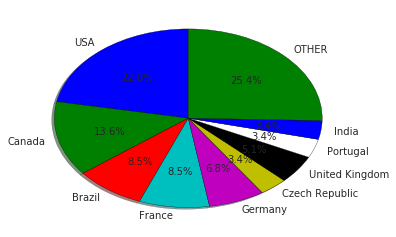

In [33]:
labels = data['country']#.tolist()
sizes = data['customers']
fig, ax1 = plt.subplots()
ax1 = plt.pie(x = data.loc[:,'customers'],
              labels = data.loc[:,'country'],
              autopct='%1.1f%%',
              shadow = True, startangle = 90)
plt.show()

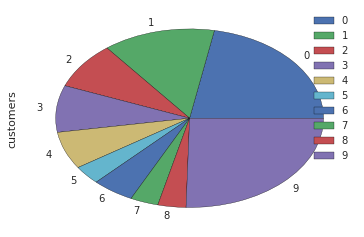

In [34]:
data.plot.pie(y = 'customers', x = 'country')

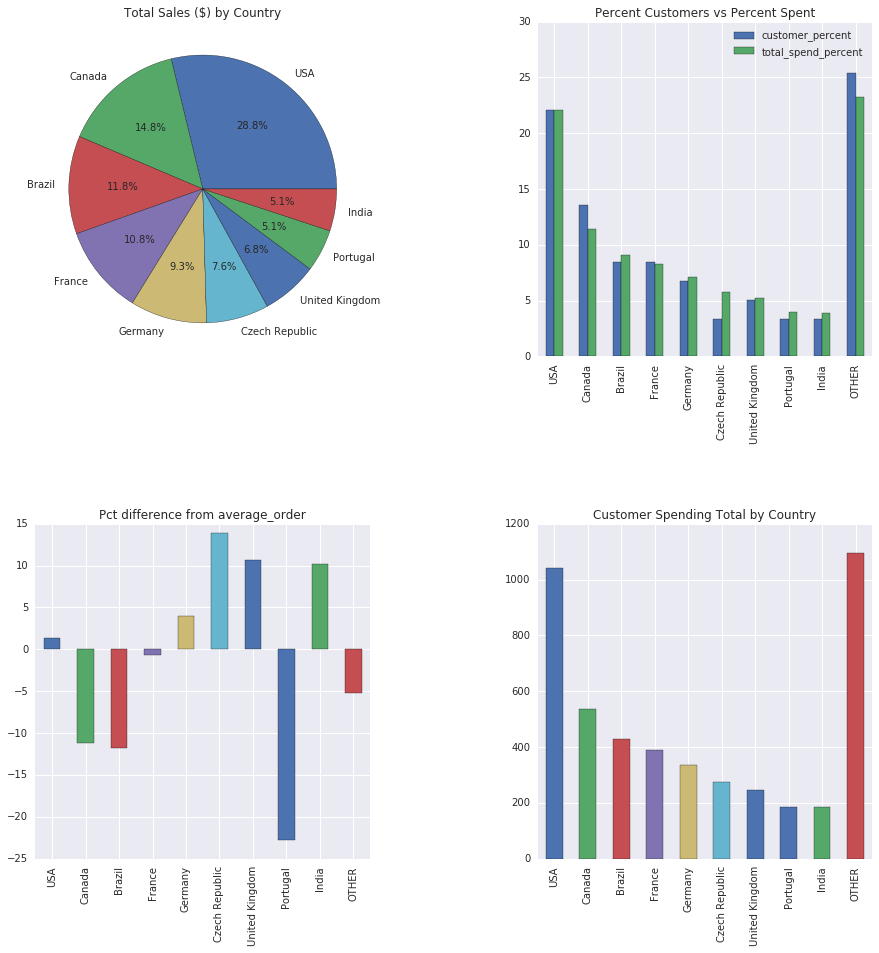

In [35]:
country_metrics = data.copy()
country_metrics.set_index('country', drop = True, inplace = True)
colors = [plt.cm.Accent(i) for i in np.linspace(0,1,country_metrics.shape[0])]

fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace = .5 , wspace =.5)

# Top left, make a pie chart of the total sales
country_metrics.iloc[:-1]['total_sales'].plot.pie(ax = ax1,
                                                 autopct = '%1.1f%%',
                                                 title = 'Total Sales ($) by Country')
ax1.set_ylabel('')

#Top Right Comparing the total number of customers to the total money spent bar plot
# Find customer percentage
country_metrics['customer_percent'] = country_metrics['customers'] / country_metrics['customers'].sum() * 100
country_metrics['total_spend_percent'] = country_metrics['total_sales'] / country_metrics['total_sales'].sum() *100

country_metrics[['customer_percent', 'total_spend_percent']].plot.bar(ax = ax2,
                                                                      title = 'Percent Customers vs Percent Spent')
ax2.set_ylabel('')
ax2.set_xlabel('')

# Lower left 
((country_metrics['average_order'] - country_metrics['average_order'].mean())
 / country_metrics['average_order'] * 100).plot.bar(ax = ax3, title = 'Pct difference from average_order')
ax3.set_ylabel('')
ax3.set_xlabel('')

#Lower right 
country_metrics['total_sales'].plot.bar(ax = ax4, title = 'Customer Spending Total by Country')
ax4.set_xlabel('')
ax4.set_ylabel('')


    



In the graphs above we can see that there are not enough customers in this shop to draw any real conclusions. It can be said however, that the two czech customers spent the most on average. A large part of the customer base is in the USA, so it would be prudent to expand the advertising there. In an online shop the amount of customers is more important than the average spending per customer unless you have some sort of market saturation.

In [61]:
q5 = '''

WITH singles AS
    (SELECT
    MIN(il.track_id) id_min,
    t.album_id,
    il.invoice_id
    FROM invoice_line il
    LEFT JOIN track t on il.track_id = t.track_id

   
    GROUP BY il.invoice_id)
    
SELECT purchase_type,
COUNT(purchase_type) purchases,
CAST(COUNT(purchase_type) AS FLOAT) / (SELECT COUNT(invoice_id) FROM invoice) *100 purchase_pct

FROM
(SELECT 
CASE
WHEN(
    SELECT il.track_id 
    FROM invoice_line il
    WHERE il.invoice_id = s.invoice_id

EXCEPT

    SELECT t.track_id 
    FROM track t
    WHERE t.album_id = s.album_id) /*(SELECT t2.album_id FROM track t2
                         WHERE t2.track_id = s.id_min))*/

IS NULL

AND

    (SELECT t.track_id 
    FROM track t
    WHERE t.album_id = s.album_id /*(SELECT t2.album_id FROM track t2
                         WHERE t2.track_id = s.id_min)*/

EXCEPT

    SELECT il.track_id 
    FROM invoice_line il
    WHERE il.invoice_id = s.invoice_id)
    
IS NULL

THEN 'album'
ELSE 'songs'


END
AS 'purchase_type'

FROM singles s)

GROUP BY purchase_type
    '''





#This query finds a single album_id for each invoice



run_query(q5)

,purchase_type,purchases,purchase_pct
0,album,114,18.566775
1,songs,500,81.433225


A large majority of the purchased songs are sold as individual songs, not as whole albums. This means album purchases do contribute to a part of the revenue, but the 18% should be weighted against the extra cost of additionally purchasing albums. Maybe reducing the amount of bought albums from not so popular artists might be a good compromise